# импорт

In [1]:
import numpy as np
import pandas as pd
import copy

%matplotlib inline
import matplotlib.pylab as plt

import sys 
sys.path.append('../pattern_recognition')

from preprocessing import *
from clustering import *
from predicting import *

In [2]:
# dataset from SBER share prices for 2021
df = pd.read_csv("minutes_21.csv")
df.head()

begin    open   close    high     low        value
0  2021-01-04 09:59:00  274.67  274.67  274.67  274.67   33910758.2
1  2021-01-04 10:00:00  274.67  274.00  274.67  273.10  236436377.8
2  2021-01-04 10:01:00  274.00  273.77  274.44  273.72   56647825.9
3  2021-01-04 10:02:00  273.76  273.63  273.84  273.38   55542122.2
4  2021-01-04 10:03:00  273.52  273.71  274.00  273.52   59676343.0

# кластеризация

In [3]:
arr_stand, arr_predict, scaler = data_division(data=df, column_value='open', period=30, step=10, \
                                               rolling_period=3, predict_period=10, train_sample=2000, column_time='begin', seed=0)

Размер всей выборки: (20224, 40)
Размер итоговой выборки: (2000, 40, 1)


In [4]:
param_dict = optimize(data=arr_stand, all_clusters_min_max_step=(10,70,10), \
                      best_clusters=10, n_trials=5, seed=0)

[I 2023-05-04 15:58:47,103] A new study created in memory with name: no-name-72bf0bf9-9987-4bcc-a211-65c64badc3d3


n_clusters = 10:


[I 2023-05-04 16:00:14,299] Trial 0 finished with value: 0.6601303876317635 and parameters: {'n_clusters': 10}. Best is trial 0 with value: 0.6601303876317635.
[I 2023-05-04 16:00:14,301] Trial 1 pruned. 


Итерация 1/5 завершена, обработка 10 кластеров заняла 1.45 минут
n_clusters = 10:
Итерация 2/5 завершена в связи с повтором параметров
n_clusters = 40:


[I 2023-05-04 16:04:43,481] Trial 2 finished with value: 0.3476105039741802 and parameters: {'n_clusters': 40}. Best is trial 2 with value: 0.3476105039741802.


Итерация 3/5 завершена, обработка 40 кластеров заняла 4.48 минут
n_clusters = 30:


[I 2023-05-04 16:08:41,286] Trial 3 finished with value: 0.39924097707932377 and parameters: {'n_clusters': 30}. Best is trial 2 with value: 0.3476105039741802.


Итерация 4/5 завершена, обработка 30 кластеров заняла 3.96 минут
n_clusters = 60:


[I 2023-05-04 16:15:58,085] Trial 4 finished with value: 0.3401616131327412 and parameters: {'n_clusters': 60}. Best is trial 4 with value: 0.3401616131327412.


Итерация 5/5 завершена, обработка 60 кластеров заняла 7.28 минут


Лучшие параметры: {'n_clusters': 60}


# визуализация

In [5]:
param_dict['n_clusters']

60

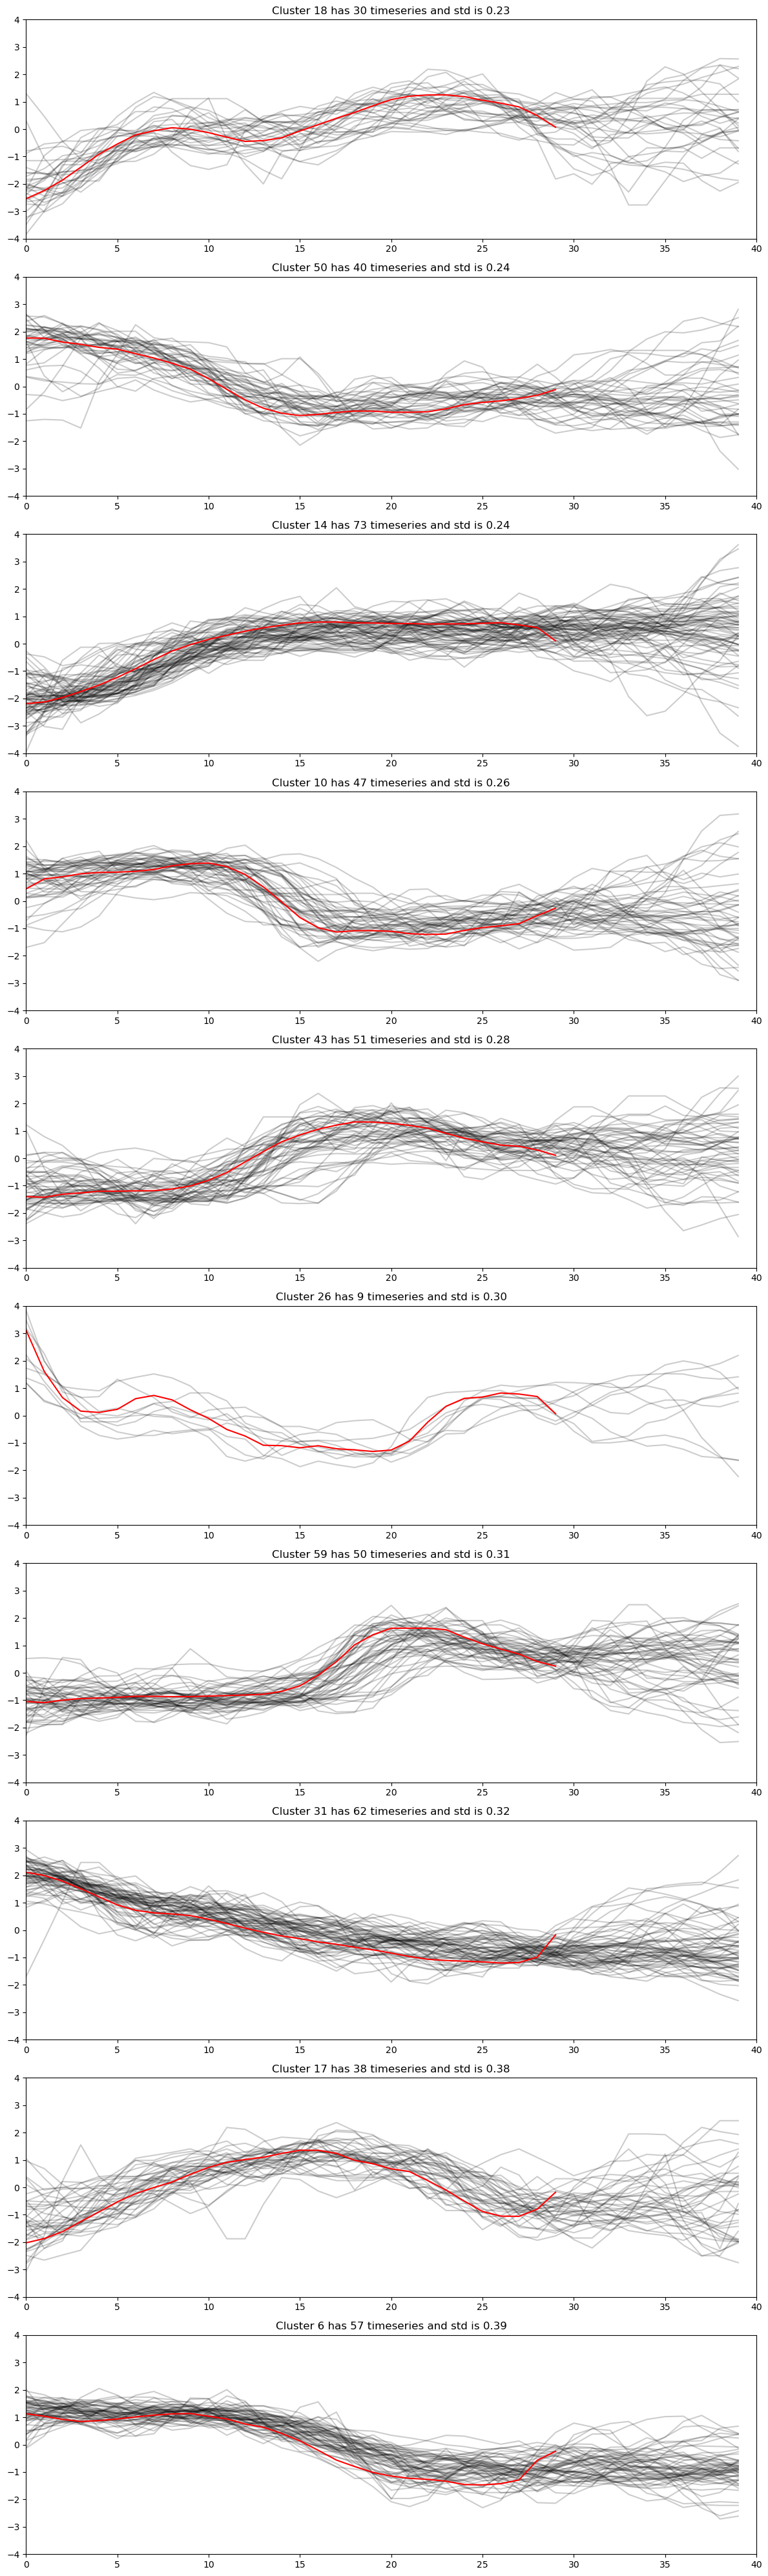

In [5]:
ks = model_kshape(n_clusters=param_dict['n_clusters'], seed=0)
ks.train(data=arr_stand)
ks.visualize_with_predict(df=arr_predict, data=arr_stand, n_best=10)

возьмем для прогноза 6й и 14й кластеры

6й - опускается в первой трети, 14й поднимается в первой трети периода, а на прогнозном отрезке оба ведут себя довольно предсказуемо, что может означать, что есть закономерность и на ней можно обучить нейросеть

In [6]:
ks.save('ks_trained_4')

# прогноз с помощью LSTM

In [3]:
arr_stand_all, arr_predict_all, scaler_all = data_division(data=df, column_value='open', period=30, step=10, \
                          rolling_period=3, predict_period=10, train_sample=10000, column_time='begin', seed=0)

Размер всей выборки: (20224, 40)
Размер итоговой выборки: (10000, 40, 1)


In [4]:
trained_ks = KShape.from_hdf5('../models/ks_trained_4.hdf5')
y_pred = trained_ks.predict(arr_stand_all)

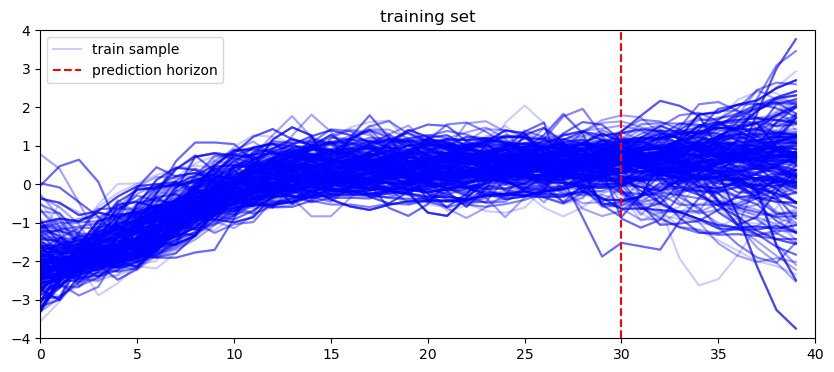

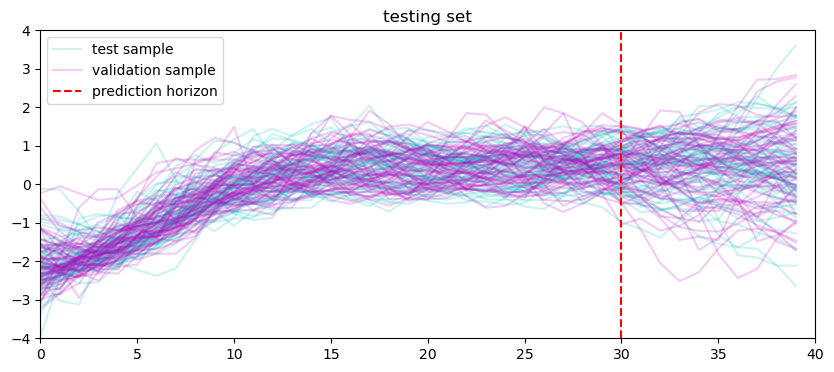

[1/100] Training loss: 0.8082	 Validation loss: 0.7704
[2/100] Training loss: 0.6641	 Validation loss: 0.5697
[3/100] Training loss: 0.4485	 Validation loss: 0.3878
[4/100] Training loss: 0.3276	 Validation loss: 0.3043
[5/100] Training loss: 0.2739	 Validation loss: 0.2669
[6/100] Training loss: 0.2456	 Validation loss: 0.2508
[7/100] Training loss: 0.2316	 Validation loss: 0.2424
[8/100] Training loss: 0.2180	 Validation loss: 0.2375
[9/100] Training loss: 0.2157	 Validation loss: 0.2359
[10/100] Training loss: 0.2092	 Validation loss: 0.2345
[20/100] Training loss: 0.1683	 Validation loss: 0.2100
[30/100] Training loss: 0.1474	 Validation loss: 0.2044
[40/100] Training loss: 0.1339	 Validation loss: 0.1923
[50/100] Training loss: 0.1286	 Validation loss: 0.1922
[60/100] Training loss: 0.1218	 Validation loss: 0.1946
[70/100] Training loss: 0.1146	 Validation loss: 0.1972
[80/100] Training loss: 0.1108	 Validation loss: 0.1996
[90/100] Training loss: 0.1044	 Validation loss: 0.2109
[

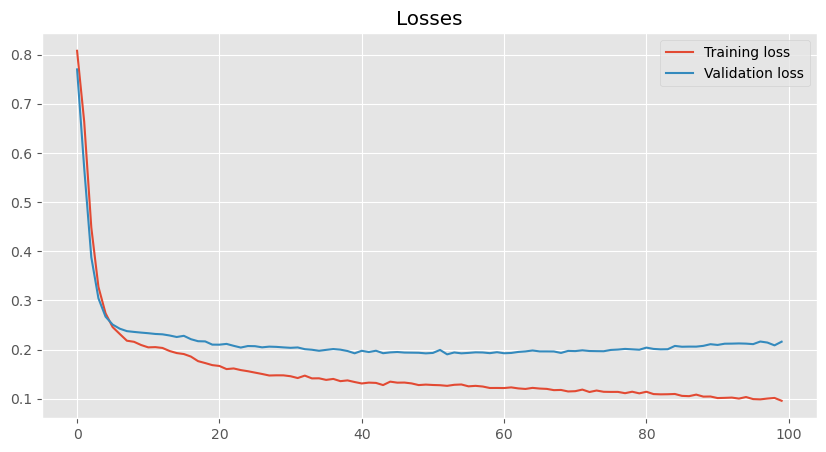

avg R2: -0.42, avg MSE: 0.14
med R2: 0.04, med MSE: 0.08


In [8]:
# predict cluster 14

# prepare data inside predicting module
Create_Dataloaders(cluster=14, data_stand=arr_predict_all, y_pred_cl=y_pred,
        batchs_size=10, bootstrap_times=3, predict_period=10,
        test_set=0.2, val_set=0.2, seed=0)

# train model inside predicting module and return: predictions, y_test, model parameters
predictions, values, model_dict = General_Settings(input_dim = 30, output_dim = 10,
                                        hidden_dim = 10, layer_dim = 2, dropout = 0.05,
                                        n_epochs = 100, learning_rate = 1e-3, weight_decay = 1e-6)
Quality_Check(predictions, values)

30 эпох хватило чтобы обучиться, но видно что модель не переобучилась

посмотрим на результаты:

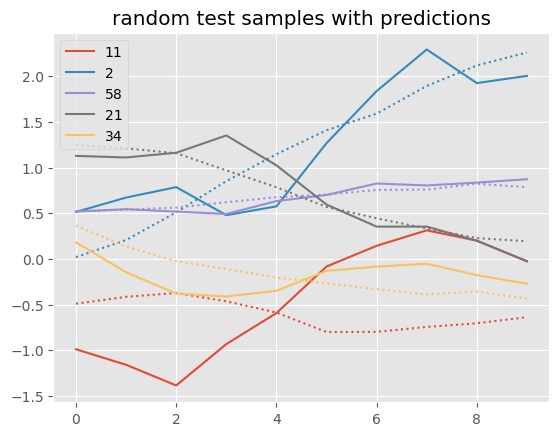

In [14]:
# 5 random predictions from test sample, which WASN'T used in model training
n = 5
choices = list(np.random.choice(range(len(predictions)),5,replace=False))

for i in choices:
    p = plt.plot(values[i][0])
    color = p[0].get_color()
    plt.plot(predictions[i][0], ':', color=color, label='_nolegend_')
plt.legend(choices, loc='upper left')
plt.title('random test samples with predictions')
plt.show()

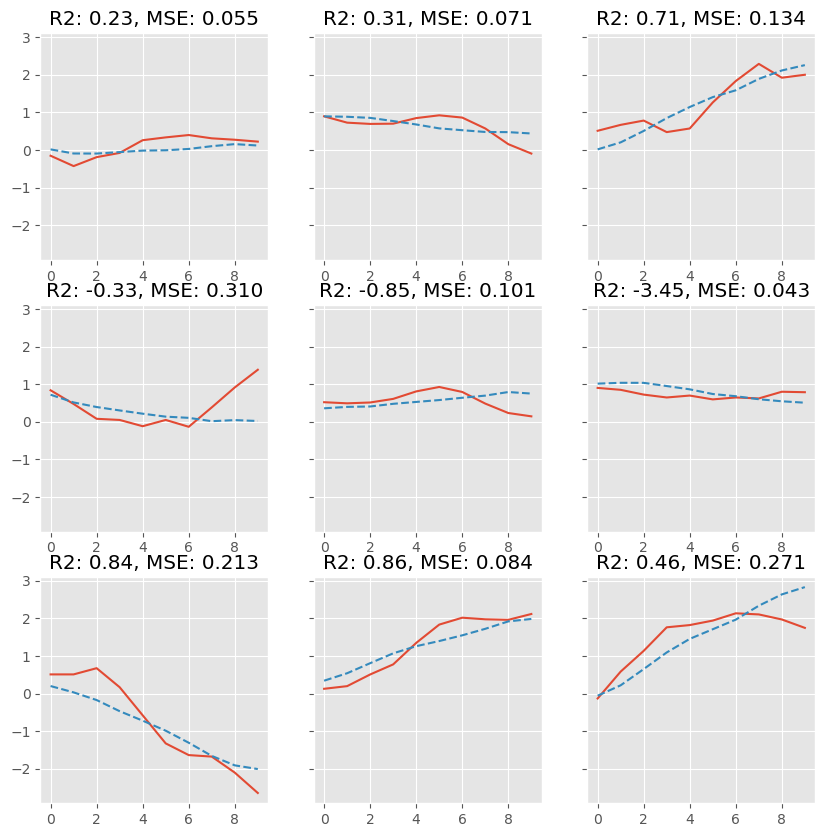

In [10]:
# first 9 examples from test sample, which WASN'T used in model training
# for better understanding of R2 metric set sharey=False
fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharey=True)
for i in range(9):
    axs[int(i/3), i%3].plot(values[i][0])
    axs[int(i/3), i%3].plot(predictions[i][0],'--')
    axs[int(i/3), i%3].title.set_text('R2: %.2f, MSE: %.3f'%(r2_score(values[i][0],predictions[i][0]),mean_squared_error(values[i][0],predictions[i][0])))

модель хорошо повторяет тренд на 10 минут, однако точно предсказать краткосрочные отклонения в 1-2 минуты не удалось

In [15]:
# сохраняем
PATH = f'../models/lstm_model_1.pt'
torch.save(model_dict, PATH)

In [ ]:
# если нужно загрузить модель
#model = CustomModel()
#model_state_dict = torch.load(PATH)
#model.load_state_dict(model_state_dict) 
#model.eval()